# Fashion MNIST example

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Make pipeline using Tensorflow Dataset API

Extracting ./fashion_mnist\train-images-idx3-ubyte.gz
Extracting ./fashion_mnist\train-labels-idx1-ubyte.gz
Extracting ./fashion_mnist\t10k-images-idx3-ubyte.gz
Extracting ./fashion_mnist\t10k-labels-idx1-ubyte.gz
label =  2


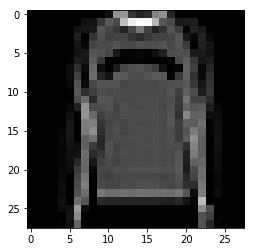

In [2]:
mnist_folder = './fashion_mnist'
mnist = input_data.read_data_sets(mnist_folder, one_hot=True)

train_data = tf.data.Dataset.from_tensor_slices((mnist.train.images, mnist.train.labels))
val_data = tf.data.Dataset.from_tensor_slices((mnist.validation.images, mnist.validation.labels))
test_data = tf.data.Dataset.from_tensor_slices((mnist.test.images, mnist.test.labels))

index = 100
print("label = ", np.argmax(mnist.train.labels[index]))
plt.imshow(mnist.train.images[index].reshape(28, 28), cmap='gray')
plt.show()

In [3]:
# hyper parameters
n_samples = 55000
n_test = 10000
n_classes = 10
batch_size = 128
is_training = False
_BATCH_NORM_DECAY = 0.997
_BATCH_NORM_EPSILON = 1e-5

gstep = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
lr = 0.001

In [4]:
_seed = tf.set_random_seed(1777)

def augmentation(image, label):
    with tf.name_scope('augmentation'):
        image = tf.reshape(image, shape=[28, 28, 1])
        image = tf.image.random_flip_left_right(image, seed=_seed) # random vertical flip
        image = tf.image.random_flip_up_down(image, seed=_seed) # random horizeontal flip
        
        # random rotate an image counter-clockwise by 90 degrees.
        rnd_rot90 = tf.cast(tf.random_uniform([], maxval=2, dtype=tf.int32, seed=_seed), tf.bool)
        rnd_degree = tf.random_uniform([], maxval=3, dtype=tf.int32, seed=_seed)
        image = tf.cond(rnd_rot90,
                    lambda: tf.image.rot90(image, k=rnd_degree),
                    lambda: tf.identity(image))
        
        # random crop
        ori_image_shape = tf.shape(image)
        rnd_crop = tf.random_uniform([], maxval=10, dtype=tf.int32, seed=_seed)
        crop_size = 28 + rnd_crop
        image = tf.image.resize_images(image, [crop_size, crop_size])
        image = tf.random_crop(image, ori_image_shape, seed=_seed)
        image = tf.reshape(image, shape=[784])

        return image, label

In [5]:
with tf.name_scope('Dataset'):
    train_aug_data = train_data.map(augmentation).shuffle(55000).batch(batch_size)
    val_data = val_data.batch(batch_size)
    test_data = test_data.batch(batch_size)
    
    iterator = tf.data.Iterator.from_structure(train_aug_data.output_types,
                                               train_aug_data.output_shapes)
    x_image, y_label = iterator.get_next()

    train_init = iterator.make_initializer(train_aug_data)
    val_init = iterator.make_initializer(val_data)
    test_init = iterator.make_initializer(test_data)

## 2. Build model (refer to [tensorflow official resnet](https://github.com/tensorflow/models/blob/master/official/resnet/resnet_model.py) and [[2]](https://github.com/kefth/fashion-mnist/blob/master/model.py))

In [6]:
# resnet v2
def resnet_block(inputs, _filters, _strides=1, projection_shortcut=False): 
    out = tf.layers.batch_normalization(inputs, 1, _BATCH_NORM_DECAY, _BATCH_NORM_EPSILON,
                                        training=is_training)
    out = tf.nn.relu(out)
    
    if projection_shortcut:
        shortcut = tf.layers.conv2d(out, _filters, 1, _strides, 'valid', 'channels_first', use_bias=False,
                                    kernel_initializer=tf.variance_scaling_initializer())
        print('use projection shortcut')
    else:
        shortcut = tf.identity(inputs)
    print('shortcut shape : {}'.format(np.shape(shortcut)))
    
    # if stride is not 1, add 'little' padding
    if not _strides == 1:
        out = tf.pad(inputs, [[0, 0], [0, 0], [1, 1], [1, 1]])
        # [[0, 0], [0, 0], [1, 1], [1, 1]] pad will added
        # channels_first data format : [batch, channels, height_in, width_in]
    else:
        out = tf.identity(inputs)
    
    out = tf.layers.conv2d(out, _filters, 3, _strides,
                           'same' if _strides == 1 else 'valid', 'channels_first',
                           use_bias=False, kernel_initializer=tf.variance_scaling_initializer())
    out = tf.layers.batch_normalization(out, 1, _BATCH_NORM_DECAY, _BATCH_NORM_EPSILON,
                                           training=is_training)
    out = tf.nn.relu(out)
    out = tf.layers.conv2d(out, _filters, 3, 1, 'same', 'channels_first',
                           use_bias=False, kernel_initializer=tf.variance_scaling_initializer())
    out = tf.add(out, shortcut)
    
    print('ResNet block output shape : {}'.format(np.shape(out)))
    return out

def avg_pooling(inputs):
    shape = inputs.get_shape().as_list()
    in_channel = [shape[2], shape[3]] # if not channels_first, then (shape[1], shape[2])
    
    out = tf.layers.batch_normalization(inputs, 1, _BATCH_NORM_DECAY, _BATCH_NORM_EPSILON,
                                           training=is_training)
    out = tf.nn.relu(out)
    out = tf.layers.average_pooling2d(out, in_channel, 1, 'valid', 'channels_first')
    
    print('Average pooling output shape : {}'.format(np.shape(out)))
    return out

In [7]:
# Resnet 18-layer like model for fashion mnist
image = tf.reshape(tensor=x_image, shape=[-1, 28, 28, 1])

# for boost GPU processing | change data format to NCHW (Tensorflow defalut is NHWC)
resnet = tf.transpose(image, [0, 3, 1, 2])
print('input shape : {}'.format(np.shape(resnet)))

resnet = tf.layers.conv2d(resnet, 64, 3, 1, 'same', 'channels_first', use_bias=False, 
                          kernel_initializer=tf.variance_scaling_initializer())

# 1st ResNet block 
resnet = resnet_block(resnet, 64)
resnet = resnet_block(resnet, 64)
# output shape [-1, 28, 28, 64]

# 2nd ResNet block
resnet = resnet_block(resnet, 128, 2, projection_shortcut=True)
resnet = resnet_block(resnet, 128)
# output shape [-1, 14, 14, 128]

# 3rd ResNet block
resnet = resnet_block(resnet, 256, 2, projection_shortcut=True)
resnet = resnet_block(resnet, 256)
# output shape [-1, 7, 7, 256]

resnet = avg_pooling(resnet)
# output shape [-1, 1, 1, 256]

resnet = tf.layers.flatten(resnet)
print('after flatten output shape : {}'.format(np.shape(resnet)))
# output shape [-1, 256]
logits = tf.layers.dense(resnet, n_classes, name='Logits')

input shape : (?, 1, 28, 28)
shortcut shape : (?, 64, 28, 28)
ResNet block output shape : (?, 64, 28, 28)
shortcut shape : (?, 64, 28, 28)
ResNet block output shape : (?, 64, 28, 28)
use projection shortcut
shortcut shape : (?, 128, 14, 14)
ResNet block output shape : (?, 128, 14, 14)
shortcut shape : (?, 128, 14, 14)
ResNet block output shape : (?, 128, 14, 14)
use projection shortcut
shortcut shape : (?, 256, 7, 7)
ResNet block output shape : (?, 256, 7, 7)
shortcut shape : (?, 256, 7, 7)
ResNet block output shape : (?, 256, 7, 7)
Average pooling output shape : (?, 256, 1, 1)
after flatten output shape : (?, 256)


## 3. Define Loss Function / Optimizer / Prediction / Tensorboard scalar

In [8]:
with tf.name_scope('loss'):
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_label, logits=logits)
    loss = tf.reduce_mean(entropy, name='loss')

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

with tf.name_scope('predict'):
    preds = tf.nn.softmax(logits)
    correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_label, 1))
    accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
    
with tf.name_scope('summaries'):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('accuracy', accuracy)
    summary_op = tf.summary.merge_all()
    
saver = tf.train.Saver(tf.global_variables())

## 4. Training & Test our model

In [9]:
total_epochs = 200

with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('./model')
    # if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    #     saver.restore(sess, ckpt.model_checkpoint_path)
    # else:
    #     sess.run(tf.global_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('./graphs/fashion_mnist', sess.graph)
    print('--- Start learning rate is {} ---'.format(lr))
    step = gstep.eval()

    for i in range(total_epochs):
        if i == (total_epochs * 0.5) or i == (total_epochs * 0.75):
            lr = lr / 10
            print('--- Decrease learning rate to {} ---'.format(lr))
        
        start_time = time.time()
        train_aug_data = lambda: train_data.map(augmentation).shuffle(50000).batch(batch_size)
        sess.run(train_init)
        is_training = True
        total_loss, n_batches = 0, 0
        try:
            while True:
                _, l, summary = sess.run([optimizer, loss, summary_op])
                writer.add_summary(summary, global_step=step)
                step += 1
                n_batches += 1
                total_loss += l
        except tf.errors.OutOfRangeError:
            pass
        
        print('Epoch {0}: loss = {1:0.6f} | Took : {2:0.4f} sec'.format(
              i+1, total_loss/n_samples, time.time() - start_time))
        
        is_training = False
        sess.run(val_init)
        total_correct_train = 0
        try:
            while True:
                accuracy_train, summaries = sess.run([accuracy, summary_op])
                writer.add_summary(summaries, global_step=step)
                total_correct_train += accuracy_train
        except tf.errors.OutOfRangeError:
            pass
        
        print('Validation Accuracy {0:0.4f}'.format(total_correct_train/5000))
        
        if (i+1) % 10 == 0:
            # for calculate test accuracy
            sess.run(test_init)
            total_correct_preds = 0
            try:
                while True:
                    accuracy_test, summaries = sess.run([accuracy, summary_op])
                    writer.add_summary(summaries, global_step=step)
                    total_correct_preds += accuracy_test
            except tf.errors.OutOfRangeError:
                pass
        
            print('*** Test Accuracy {0:0.4f} ***'.format(total_correct_preds/n_test))
    
    writer.close()
    saver.save(sess=sess, save_path='./model/fmnist_resnet.ckpt')

--- Start learning rate is 0.001 ---
Epoch 1: loss = 0.009172 | Took : 47.1050 sec
Validation Accuracy 0.7834
Epoch 2: loss = 0.005780 | Took : 45.5730 sec
Validation Accuracy 0.7880
Epoch 3: loss = 0.004732 | Took : 47.1272 sec
Validation Accuracy 0.8452
Epoch 4: loss = 0.004225 | Took : 46.8768 sec
Validation Accuracy 0.8478
Epoch 5: loss = 0.003865 | Took : 44.4429 sec
Validation Accuracy 0.8658
Epoch 6: loss = 0.003644 | Took : 44.7682 sec
Validation Accuracy 0.8850
Epoch 7: loss = 0.003460 | Took : 44.7885 sec
Validation Accuracy 0.8936
Epoch 8: loss = 0.003352 | Took : 44.5969 sec
Validation Accuracy 0.8836
Epoch 9: loss = 0.003248 | Took : 44.2172 sec
Validation Accuracy 0.8926
Epoch 10: loss = 0.003132 | Took : 44.2866 sec
Validation Accuracy 0.8980
*** Test Accuracy 0.8903 ***
Epoch 11: loss = 0.002996 | Took : 44.7303 sec
Validation Accuracy 0.8882
Epoch 12: loss = 0.002980 | Took : 44.2459 sec
Validation Accuracy 0.8924
Epoch 13: loss = 0.002916 | Took : 44.1897 sec
Validati